In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(364416, 828)
(364416, 1)
validation
(50712, 828)
(50712, 1)
test
(49296, 828)
(49296, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 57s - loss: 0.0693 - STD: 1.8256e-04 - MAE: 0.2527

 4/37 [==>...........................] - ETA: 1s - loss: 0.0344 - STD: 3.5670e-04 - MAE: 0.1419 

 5/37 [===>..........................] - ETA: 1s - loss: 0.0345 - STD: 3.2908e-04 - MAE: 0.1428

 6/37 [===>..........................] - ETA: 2s - loss: 0.0340 - STD: 3.1008e-04 - MAE: 0.1419

 7/37 [====>.........................] - ETA: 2s - loss: 0.0334 - STD: 3.0259e-04 - MAE: 0.1401

 8/37 [=====>........................] - ETA: 2s - loss: 0.0323 - STD: 3.0607e-04 - MAE: 0.1363

 9/37 [======>.......................] - ETA: 2s - loss: 0.0309 - STD: 3.1967e-04 - MAE: 0.1308

10/37 [=======>......................] - ETA: 2s - loss: 0.0294 - STD: 3.3935e-04 - MAE: 0.1244

11/37 [=======>......................] - ETA: 2s - loss: 0.0279 - STD: 3.6342e-04 - MAE: 0.1195

12/37 [========>.....................] - ETA: 2s - loss: 0.0268 - STD: 3.8899e-04 - MAE: 0.1171

13/37 [=========>....................] - ETA: 2s - loss: 0.0261 - STD: 4.1508e-04 - MAE: 0.1167

14/37 [==========>...................] - ETA: 2s - loss: 0.0255 - STD: 4.3912e-04 - MAE: 0.1171

15/37 [===========>..................] - ETA: 2s - loss: 0.0251 - STD: 4.6319e-04 - MAE: 0.1177

16/37 [===========>..................] - ETA: 1s - loss: 0.0247 - STD: 4.8464e-04 - MAE: 0.1177

17/37 [============>.................] - ETA: 1s - loss: 0.0241 - STD: 5.0478e-04 - MAE: 0.1169

18/37 [=============>................] - ETA: 1s - loss: 0.0236 - STD: 5.2346e-04 - MAE: 0.1153

19/37 [==============>...............] - ETA: 1s - loss: 0.0230 - STD: 5.3991e-04 - MAE: 0.1132

20/37 [===============>..............] - ETA: 2s - loss: 0.0228 - STD: 5.5438e-04 - MAE: 0.1108

23/37 [=================>............] - ETA: 1s - loss: 0.0217 - STD: 5.9225e-04 - MAE: 0.1048

24/37 [==================>...........] - ETA: 1s - loss: 0.0215 - STD: 6.0501e-04 - MAE: 0.1032

25/37 [===================>..........] - ETA: 1s - loss: 0.0212 - STD: 6.1866e-04 - MAE: 0.1016

26/37 [====================>.........] - ETA: 1s - loss: 0.0209 - STD: 6.3457e-04 - MAE: 0.1001

27/37 [====================>.........] - ETA: 1s - loss: 0.0207 - STD: 6.5218e-04 - MAE: 0.0988

28/37 [=====================>........] - ETA: 1s - loss: 0.0204 - STD: 6.7153e-04 - MAE: 0.0976

29/37 [======================>.......] - ETA: 0s - loss: 0.0202 - STD: 6.9428e-04 - MAE: 0.0968

30/37 [=======================>......] - ETA: 0s - loss: 0.0200 - STD: 7.1892e-04 - MAE: 0.0963

31/37 [========================>.....] - ETA: 0s - loss: 0.0197 - STD: 7.4479e-04 - MAE: 0.0959

32/37 [========================>.....] - ETA: 0s - loss: 0.0195 - STD: 7.7235e-04 - MAE: 0.0956

33/37 [=========================>....] - ETA: 0s - loss: 0.0194 - STD: 8.0175e-04 - MAE: 0.0955

34/37 [==========================>...] - ETA: 0s - loss: 0.0192 - STD: 8.3251e-04 - MAE: 0.0954

35/37 [===========================>..] - ETA: 0s - loss: 0.0190 - STD: 8.6358e-04 - MAE: 0.0952

36/37 [============================>.] - ETA: 0s - loss: 0.0189 - STD: 8.9541e-04 - MAE: 0.0948

37/37 [==============================] - ETA: 0s - loss: 0.0187 - STD: 9.2768e-04 - MAE: 0.0944

37/37 [==============================] - 6s 132ms/step - loss: 0.0187 - STD: 9.2768e-04 - MAE: 0.0944 - val_loss: 0.0137 - val_STD: 0.0017 - val_MAE: 0.0846


Epoch 2/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0133 - STD: 0.0022 - MAE: 0.0741

 2/37 [>.............................] - ETA: 3s - loss: 0.0132 - STD: 0.0022 - MAE: 0.0719

 3/37 [=>............................] - ETA: 3s - loss: 0.0131 - STD: 0.0023 - MAE: 0.0701

 4/37 [==>...........................] - ETA: 3s - loss: 0.0131 - STD: 0.0023 - MAE: 0.0688

 5/37 [===>..........................] - ETA: 3s - loss: 0.0130 - STD: 0.0024 - MAE: 0.0677

 6/37 [===>..........................] - ETA: 3s - loss: 0.0131 - STD: 0.0025 - MAE: 0.0674

 7/37 [====>.........................] - ETA: 3s - loss: 0.0130 - STD: 0.0026 - MAE: 0.0670

 8/37 [=====>........................] - ETA: 3s - loss: 0.0130 - STD: 0.0027 - MAE: 0.0670

 9/37 [======>.......................] - ETA: 2s - loss: 0.0130 - STD: 0.0028 - MAE: 0.0672

10/37 [=======>......................] - ETA: 2s - loss: 0.0130 - STD: 0.0029 - MAE: 0.0677

11/37 [=======>......................] - ETA: 2s - loss: 0.0129 - STD: 0.0030 - MAE: 0.0682

12/37 [========>.....................] - ETA: 2s - loss: 0.0129 - STD: 0.0032 - MAE: 0.0689

13/37 [=========>....................] - ETA: 2s - loss: 0.0128 - STD: 0.0033 - MAE: 0.0696

14/37 [==========>...................] - ETA: 2s - loss: 0.0128 - STD: 0.0035 - MAE: 0.0703

15/37 [===========>..................] - ETA: 2s - loss: 0.0129 - STD: 0.0037 - MAE: 0.0709

16/37 [===========>..................] - ETA: 2s - loss: 0.0128 - STD: 0.0038 - MAE: 0.0712

17/37 [============>.................] - ETA: 2s - loss: 0.0128 - STD: 0.0040 - MAE: 0.0714

18/37 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 0.0042 - MAE: 0.0714

19/37 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 0.0044 - MAE: 0.0713

20/37 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 0.0047 - MAE: 0.0710

21/37 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 0.0049 - MAE: 0.0708

22/37 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 0.0051 - MAE: 0.0705

23/37 [=================>............] - ETA: 1s - loss: 0.0125 - STD: 0.0054 - MAE: 0.0703

24/37 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 0.0057 - MAE: 0.0700

25/37 [===================>..........] - ETA: 1s - loss: 0.0124 - STD: 0.0061 - MAE: 0.0698

26/37 [====================>.........] - ETA: 1s - loss: 0.0123 - STD: 0.0064 - MAE: 0.0696

27/37 [====================>.........] - ETA: 1s - loss: 0.0123 - STD: 0.0068 - MAE: 0.0695

28/37 [=====================>........] - ETA: 0s - loss: 0.0122 - STD: 0.0073 - MAE: 0.0694

29/37 [======================>.......] - ETA: 0s - loss: 0.0122 - STD: 0.0078 - MAE: 0.0694

30/37 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 0.0083 - MAE: 0.0693

32/37 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 0.0095 - MAE: 0.0688

33/37 [=========================>....] - ETA: 0s - loss: 0.0118 - STD: 0.0101 - MAE: 0.0685

34/37 [==========================>...] - ETA: 0s - loss: 0.0117 - STD: 0.0108 - MAE: 0.0681

35/37 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0116 - MAE: 0.0676

36/37 [============================>.] - ETA: 0s - loss: 0.0115 - STD: 0.0124 - MAE: 0.0672

37/37 [==============================] - ETA: 0s - loss: 0.0114 - STD: 0.0133 - MAE: 0.0667

37/37 [==============================] - 4s 104ms/step - loss: 0.0114 - STD: 0.0133 - MAE: 0.0667 - val_loss: 0.0071 - val_STD: 0.0394 - val_MAE: 0.0582


Epoch 3/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0501 - MAE: 0.0499

 2/37 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0525 - MAE: 0.0495

 4/37 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0581 - MAE: 0.0487

 5/37 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0478

 6/37 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0471

 7/37 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0463

 8/37 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0457

 9/37 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0450

10/37 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0444

11/37 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0439

12/37 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0734 - MAE: 0.0434

13/37 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0750 - MAE: 0.0429

14/37 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0425

15/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0421

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0417

17/37 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0414

18/37 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0807 - MAE: 0.0410

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0407

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0822 - MAE: 0.0404

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0829 - MAE: 0.0402

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0836 - MAE: 0.0399

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0843 - MAE: 0.0397

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0853 - MAE: 0.0395

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0859 - MAE: 0.0393

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0864 - MAE: 0.0391

27/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0870 - MAE: 0.0389

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0875 - MAE: 0.0388

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0880 - MAE: 0.0386

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0886 - MAE: 0.0385

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0890 - MAE: 0.0383

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0894 - MAE: 0.0382

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0897 - MAE: 0.0381

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0900 - MAE: 0.0379

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0378

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0377

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0376

37/37 [==============================] - 4s 99ms/step - loss: 0.0035 - STD: 0.0908 - MAE: 0.0376 - val_loss: 0.0027 - val_STD: 0.0955 - val_MAE: 0.0342


Epoch 4/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0344

 2/37 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1020 - MAE: 0.0342

 3/37 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1014 - MAE: 0.0340

 4/37 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1021 - MAE: 0.0338

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1021 - MAE: 0.0341

 7/37 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.1020 - MAE: 0.0341

 8/37 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.1023 - MAE: 0.0340

 9/37 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1025 - MAE: 0.0340

10/37 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1028 - MAE: 0.0341

11/37 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1026 - MAE: 0.0341

12/37 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1026 - MAE: 0.0341

13/37 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1026 - MAE: 0.0340

14/37 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1024 - MAE: 0.0340

15/37 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1024 - MAE: 0.0340

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1025 - MAE: 0.0340

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1026 - MAE: 0.0340

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1025 - MAE: 0.0339

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1027 - MAE: 0.0339

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1026 - MAE: 0.0339

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1026 - MAE: 0.0338

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1027 - MAE: 0.0338

23/37 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1026 - MAE: 0.0338

24/37 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1027 - MAE: 0.0337

25/37 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1028 - MAE: 0.0337

26/37 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0337

27/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1031 - MAE: 0.0337

28/37 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1031 - MAE: 0.0336

29/37 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1030 - MAE: 0.0336

30/37 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0336

31/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0335

32/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0335

33/37 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0335

34/37 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0335

35/37 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0335

36/37 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1028 - MAE: 0.0334

37/37 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0334

37/37 [==============================] - 4s 98ms/step - loss: 0.0026 - STD: 0.1029 - MAE: 0.0334 - val_loss: 0.0025 - val_STD: 0.0976 - val_MAE: 0.0340


Epoch 5/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1050 - MAE: 0.0329

 2/37 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0329

 3/37 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0329

 4/37 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0328

 5/37 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1045 - MAE: 0.0328

 6/37 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0328

 7/37 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0328

 8/37 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1043 - MAE: 0.0328

 9/37 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1046 - MAE: 0.0328

10/37 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1043 - MAE: 0.0328

11/37 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0327

12/37 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0327

13/37 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0327

14/37 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0327

15/37 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0327

16/37 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0327

17/37 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0326

18/37 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0326

19/37 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0326

20/37 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0326

22/37 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0325

23/37 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0325

24/37 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0325

25/37 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0325

26/37 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0325

27/37 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0325

28/37 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0325

29/37 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0325

30/37 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0324

31/37 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324

32/37 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0324

33/37 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324

34/37 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324

35/37 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324

36/37 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324

37/37 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324

37/37 [==============================] - 4s 99ms/step - loss: 0.0024 - STD: 0.1040 - MAE: 0.0324 - val_loss: 0.0025 - val_STD: 0.0952 - val_MAE: 0.0331


Epoch 6/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1038 - MAE: 0.0317

 2/37 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0321

 3/37 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1036 - MAE: 0.0320

 4/37 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0320

 5/37 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0319

 6/37 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0319

 7/37 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0318

 8/37 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0318

 9/37 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0317

10/37 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0318

11/37 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0318

12/37 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1037 - MAE: 0.0318

13/37 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0317

14/37 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1041 - MAE: 0.0317

15/37 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0317

16/37 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0317

17/37 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0317

18/37 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0317

19/37 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1041 - MAE: 0.0317

20/37 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0317

21/37 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0317

22/37 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1041 - MAE: 0.0317

23/37 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1043 - MAE: 0.0317

24/37 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1044 - MAE: 0.0317

25/37 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1044 - MAE: 0.0317

26/37 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1046 - MAE: 0.0317

27/37 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1047 - MAE: 0.0317

28/37 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1047 - MAE: 0.0317

29/37 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1045 - MAE: 0.0317

30/37 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0317

31/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0316

32/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0316

33/37 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1045 - MAE: 0.0316

34/37 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0316

36/37 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0316

37/37 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0316

37/37 [==============================] - 4s 99ms/step - loss: 0.0022 - STD: 0.1046 - MAE: 0.0316 - val_loss: 0.0024 - val_STD: 0.0959 - val_MAE: 0.0330


Epoch 7/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0310

 2/37 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0313

 3/37 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0312

 4/37 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0312

 5/37 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1055 - MAE: 0.0312

 6/37 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1058 - MAE: 0.0312

 7/37 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1060 - MAE: 0.0312

 8/37 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1057 - MAE: 0.0312

 9/37 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1054 - MAE: 0.0312

10/37 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1057 - MAE: 0.0312

11/37 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1059 - MAE: 0.0312

12/37 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1058 - MAE: 0.0312

13/37 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0312

14/37 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0311

15/37 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1058 - MAE: 0.0311

16/37 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0312

17/37 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1055 - MAE: 0.0312

18/37 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0312

19/37 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0312

20/37 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1053 - MAE: 0.0311

22/37 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0311

23/37 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0311

24/37 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0312

25/37 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0312

26/37 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0311

27/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0312

28/37 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0311

29/37 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0311

30/37 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0311

31/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0311

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0311

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0311

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0311

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0311

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0311

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0311

37/37 [==============================] - 4s 97ms/step - loss: 0.0021 - STD: 0.1055 - MAE: 0.0311 - val_loss: 0.0024 - val_STD: 0.0968 - val_MAE: 0.0327


Epoch 8/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304

 2/37 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0306

 3/37 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1053 - MAE: 0.0306

 4/37 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1047 - MAE: 0.0307

 5/37 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0307

 6/37 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1048 - MAE: 0.0306

 7/37 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0306

 9/37 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0306

10/37 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0305

11/37 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0305

12/37 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0305

13/37 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0305

14/37 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0305

15/37 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0305

16/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0305

17/37 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0305

18/37 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0305

19/37 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0306

20/37 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1052 - MAE: 0.0305

21/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0305

22/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1052 - MAE: 0.0305

23/37 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0305

24/37 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0305

25/37 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0305

26/37 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0305

27/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0305

28/37 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0305

29/37 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0305

30/37 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0306

31/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0306

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0306

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0306

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0306

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0306

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1058 - MAE: 0.0305

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1057 - MAE: 0.0305

37/37 [==============================] - 4s 98ms/step - loss: 0.0021 - STD: 0.1057 - MAE: 0.0305 - val_loss: 0.0024 - val_STD: 0.0976 - val_MAE: 0.0324


Epoch 9/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

 2/37 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0301

 3/37 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1062 - MAE: 0.0303

 4/37 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1071 - MAE: 0.0303

 5/37 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1062 - MAE: 0.0302

 6/37 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0303

 7/37 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1063 - MAE: 0.0303

 8/37 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1066 - MAE: 0.0303

 9/37 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0303

10/37 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0302

11/37 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0302

12/37 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0303

13/37 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1058 - MAE: 0.0302

15/37 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1058 - MAE: 0.0303

16/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1058 - MAE: 0.0302

17/37 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0302

18/37 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1062 - MAE: 0.0302

19/37 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0302

20/37 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0302

21/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0302

22/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0302

23/37 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0302

24/37 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0301

25/37 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0301

26/37 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0301

27/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

28/37 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

29/37 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

30/37 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1062 - MAE: 0.0301

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0301

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0301

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1060 - MAE: 0.0301

37/37 [==============================] - 4s 96ms/step - loss: 0.0020 - STD: 0.1060 - MAE: 0.0301 - val_loss: 0.0023 - val_STD: 0.1003 - val_MAE: 0.0325


Epoch 10/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1087 - MAE: 0.0297

 2/37 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1077 - MAE: 0.0299

 3/37 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1079 - MAE: 0.0296

 4/37 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1083 - MAE: 0.0295

 5/37 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1084 - MAE: 0.0295

 6/37 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1072 - MAE: 0.0297

 7/37 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1072 - MAE: 0.0297

 8/37 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1073 - MAE: 0.0297

 9/37 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0298

10/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0298

11/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1068 - MAE: 0.0297

12/37 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0298

13/37 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0299

14/37 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0299

15/37 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0299

16/37 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1066 - MAE: 0.0299

17/37 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1066 - MAE: 0.0299

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0299

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0298

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0298

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0298

22/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0298

23/37 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0298

24/37 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0298

25/37 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0299

26/37 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0299

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0299

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0300

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0299

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1064 - MAE: 0.0300

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0300

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0300

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1065 - MAE: 0.0300

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0300

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1063 - MAE: 0.0300

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1063 - MAE: 0.0300

37/37 [==============================] - 4s 99ms/step - loss: 0.0020 - STD: 0.1063 - MAE: 0.0300 - val_loss: 0.0023 - val_STD: 0.1019 - val_MAE: 0.0327


Epoch 11/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0290

 2/37 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

 3/37 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0294

 4/37 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0294

 5/37 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0293

 6/37 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0294

 7/37 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0293

 8/37 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0294

 9/37 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0295

10/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0294

11/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0294

12/37 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0294

13/37 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0294

14/37 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1068 - MAE: 0.0293

15/37 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0293

16/37 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0293

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0293

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0293

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0293

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0293

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0293

22/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0293

23/37 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0293

24/37 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0293

25/37 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0293

26/37 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0293

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0293

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0293

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0292

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0292

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0292

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0292

37/37 [==============================] - 4s 99ms/step - loss: 0.0019 - STD: 0.1064 - MAE: 0.0292 - val_loss: 0.0023 - val_STD: 0.1018 - val_MAE: 0.0322


Epoch 12/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0287

 2/37 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0289

 3/37 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0289

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0290

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0289

 7/37 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

 8/37 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0289

 9/37 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0289

10/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0289

11/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

12/37 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

13/37 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

14/37 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

15/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0289

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

22/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

23/37 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0290

24/37 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0290

25/37 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

26/37 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0289

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0289

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0289

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0289

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0289

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0289

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0289

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0289

37/37 [==============================] - 4s 99ms/step - loss: 0.0018 - STD: 0.1069 - MAE: 0.0289 - val_loss: 0.0023 - val_STD: 0.1002 - val_MAE: 0.0319


Epoch 13/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0291

 2/37 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0289

 3/37 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0288

 4/37 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0286

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0288

 7/37 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1082 - MAE: 0.0288

 8/37 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0288

 9/37 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0287

10/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0288

11/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0289

12/37 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

13/37 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

14/37 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

15/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0290

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0291

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0291

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0291

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0291

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0291

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0291

22/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0291

23/37 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

24/37 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

25/37 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

26/37 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0290

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0291

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0290

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0291

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0292

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0292

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0291

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0291

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0291

37/37 [==============================] - 4s 98ms/step - loss: 0.0018 - STD: 0.1070 - MAE: 0.0291 - val_loss: 0.0023 - val_STD: 0.1005 - val_MAE: 0.0317


Epoch 14/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0282

 2/37 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0284

 3/37 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0285

 4/37 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

 5/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0285

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0286

 7/37 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0288

 8/37 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0287

 9/37 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0287

10/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0289

12/37 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0289

13/37 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0290

14/37 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0289

15/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0288

16/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0289

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0288

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0288

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0288

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0288

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0287

22/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0287

23/37 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287

24/37 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0287

25/37 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287

26/37 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0287

27/37 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0287

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0286

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0286

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0287

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0286

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0287

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0287

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0287

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287

37/37 [==============================] - 4s 104ms/step - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287 - val_loss: 0.0023 - val_STD: 0.1012 - val_MAE: 0.0317


Epoch 15/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0280

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0275

 3/37 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0276

 4/37 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0277

 5/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0278

 6/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0278

 7/37 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

 8/37 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0279

 9/37 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0280

10/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0280

11/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0280

12/37 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0280

13/37 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0280

14/37 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

15/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0279

16/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0280

17/37 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0280

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0280

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0280

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0280

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0280

22/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0280

23/37 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0280

24/37 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0280

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0280

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0280

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0280

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0280

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0280

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0280

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0280

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0280

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0279

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0279

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0280

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0280

37/37 [==============================] - 4s 108ms/step - loss: 0.0017 - STD: 0.1074 - MAE: 0.0280 - val_loss: 0.0022 - val_STD: 0.1049 - val_MAE: 0.0327


Epoch 16/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0281

 2/37 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0284

 3/37 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0286

 4/37 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0292

 5/37 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1080 - MAE: 0.0295

 6/37 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1071 - MAE: 0.0297

 7/37 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1075 - MAE: 0.0297

 8/37 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0295

 9/37 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1078 - MAE: 0.0293

10/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0291

11/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0290

12/37 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0288

13/37 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0287

14/37 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0287

15/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0286

16/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0286

17/37 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0285

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

22/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

23/37 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0283

24/37 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0283

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0283

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0283

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0283

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0283

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0283

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0283

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0284

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0285

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0285

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0285

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0285

37/37 [==============================] - 4s 107ms/step - loss: 0.0017 - STD: 0.1076 - MAE: 0.0285 - val_loss: 0.0027 - val_STD: 0.0988 - val_MAE: 0.0347


Epoch 17/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0311

 2/37 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0298

 3/37 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0291

 4/37 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

 5/37 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0290

 6/37 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0288

 7/37 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0286

 8/37 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0285

 9/37 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

10/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0283

11/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0282

12/37 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0281

13/37 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0281

14/37 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0280

15/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0280

16/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0280

17/37 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0280

18/37 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

23/37 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

24/37 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0279

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0278

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0278

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0278

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0278

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0278

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0278

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0278

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

37/37 [==============================] - 4s 109ms/step - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279 - val_loss: 0.0023 - val_STD: 0.1012 - val_MAE: 0.0323


Epoch 18/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0284

 2/37 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0285

 3/37 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

 4/37 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0282

 5/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0280

 6/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0279

 7/37 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0279

 8/37 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0279

 9/37 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0278

10/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0278

11/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

12/37 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0278

13/37 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

14/37 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0277

15/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0277

16/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0277

17/37 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0277

18/37 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0277

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0277

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0277

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0277

22/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0277

23/37 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0277

24/37 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0277

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0277

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0277

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0277

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0278

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0279

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0279

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0279

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0279

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0279

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0279

37/37 [==============================] - 4s 110ms/step - loss: 0.0017 - STD: 0.1076 - MAE: 0.0279 - val_loss: 0.0022 - val_STD: 0.1037 - val_MAE: 0.0318


Epoch 19/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0271

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0270

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

 4/37 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0281

 5/37 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0291

 6/37 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1083 - MAE: 0.0291

 7/37 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1084 - MAE: 0.0289

 8/37 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0289

 9/37 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0289

10/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0291

11/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1078 - MAE: 0.0290

12/37 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0289

13/37 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0288

14/37 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0288

15/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0289

16/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1078 - MAE: 0.0289

17/37 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0288

18/37 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0288

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0288

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0287

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0287

22/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0286

23/37 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0286

24/37 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0286

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0285

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0285

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0285

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0285

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0285

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0284

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0284

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0284

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283

37/37 [==============================] - 4s 112ms/step - loss: 0.0017 - STD: 0.1075 - MAE: 0.0283 - val_loss: 0.0022 - val_STD: 0.1043 - val_MAE: 0.0330


Epoch 20/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0280

 2/37 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0277

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0276

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0277

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0278

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0277

 7/37 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0277

 8/37 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0278

 9/37 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1085 - MAE: 0.0278

10/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1083 - MAE: 0.0278

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0277

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0276

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0277

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

18/37 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0276

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0276

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0278

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0278

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0278

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0278

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0278

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0279

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0279

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0278

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0278

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0279

37/37 [==============================] - 4s 109ms/step - loss: 0.0017 - STD: 0.1078 - MAE: 0.0279 - val_loss: 0.0022 - val_STD: 0.1026 - val_MAE: 0.0315


Epoch 21/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0275

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0275

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1090 - MAE: 0.0276

 4/37 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1083 - MAE: 0.0281

 5/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1083 - MAE: 0.0278

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0277

 7/37 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0279

 8/37 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0279

 9/37 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0278

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0277

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0277

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0276

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0276

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0277

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0277

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0277

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0278

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0278

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0278

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0277

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0277

26/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0277

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0276

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

37/37 [==============================] - 4s 112ms/step - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277 - val_loss: 0.0022 - val_STD: 0.1041 - val_MAE: 0.0322


Epoch 22/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1119 - MAE: 0.0274

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0281

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1095 - MAE: 0.0277

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1092 - MAE: 0.0276

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1091 - MAE: 0.0276

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1091 - MAE: 0.0275

 8/37 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0275

 9/37 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1088 - MAE: 0.0274

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0275

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0276

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0277

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0276

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0276

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0276

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0276

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0276

18/37 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0276

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1088 - MAE: 0.0276

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0276

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0276

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0276

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0276

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0276

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0276

26/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0276

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0276

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0276

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0275

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0275

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0275

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0275

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0275

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0275

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0275

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

37/37 [==============================] - 4s 111ms/step - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275 - val_loss: 0.0024 - val_STD: 0.1019 - val_MAE: 0.0325


Epoch 23/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0294

 2/37 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0284

 3/37 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0281

 4/37 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0281

 5/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

 6/37 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0281

 7/37 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0280

 8/37 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

 9/37 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0278

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0278

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0278

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0278

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0278

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0278

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0277

18/37 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0277

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0277

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0276

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0278

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0278

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0279

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0278

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0278

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0278

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0278

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0277

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0277

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0277

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0277

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0276

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

37/37 [==============================] - 4s 110ms/step - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276 - val_loss: 0.0022 - val_STD: 0.1030 - val_MAE: 0.0314


Epoch 24/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0270

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0271

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0271

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0271

 7/37 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0271

 8/37 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0271

 9/37 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0271

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0272

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0272

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0272

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0273

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0273

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0273

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0273

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0272

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0272

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0272

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0272

26/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0272

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0272

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0272

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0273

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0274

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

37/37 [==============================] - 4s 110ms/step - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275 - val_loss: 0.0022 - val_STD: 0.1059 - val_MAE: 0.0332


Epoch 25/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1111 - MAE: 0.0275

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0272

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0272

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1093 - MAE: 0.0275

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0276

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0277

 7/37 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0275

 8/37 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0275

 9/37 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0275

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0275

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0275

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0274

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0274

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0273

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0274

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0274

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0273

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0274

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0274

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0274

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0274

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0275

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0275

26/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0275

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0275

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0276

37/37 [==============================] - 4s 108ms/step - loss: 0.0016 - STD: 0.1081 - MAE: 0.0276 - val_loss: 0.0022 - val_STD: 0.1028 - val_MAE: 0.0314


Epoch 26/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0274

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0271

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0270

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0269

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0269

 7/37 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0270

 8/37 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0271

 9/37 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0271

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0271

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0271

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0272

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0273

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0273

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0272

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0272

18/37 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0272

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0272

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0271

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0271

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0271

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0271

26/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0271

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0271

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0271

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0271

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0271

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0271

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0271

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0271

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0272

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0272

37/37 [==============================] - 4s 110ms/step - loss: 0.0016 - STD: 0.1083 - MAE: 0.0272 - val_loss: 0.0024 - val_STD: 0.0999 - val_MAE: 0.0326


Epoch 27/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0292

 2/37 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0294

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0288

 5/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0284

 6/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0286

 7/37 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0288

 8/37 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0290

 9/37 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0287

10/37 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0288

11/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1078 - MAE: 0.0292

12/37 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0291

13/37 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0289

14/37 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0290

15/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0290

16/37 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0289

17/37 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0288

18/37 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0287

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0287

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0286

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0286

22/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0286

23/37 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0285

24/37 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0285

25/37 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0286

26/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0285

27/37 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0285

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0287

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0286

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0286

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0287

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0287

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0287

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0288

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0288

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0289

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0291

37/37 [==============================] - 4s 112ms/step - loss: 0.0018 - STD: 0.1076 - MAE: 0.0291 - val_loss: 0.0022 - val_STD: 0.1014 - val_MAE: 0.0313


Epoch 28/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

 2/37 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0318

 3/37 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1094 - MAE: 0.0317

 4/37 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1081 - MAE: 0.0314

 5/37 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1093 - MAE: 0.0320

 6/37 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1080 - MAE: 0.0312

 7/37 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1069 - MAE: 0.0311

 8/37 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1075 - MAE: 0.0308

 9/37 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1079 - MAE: 0.0305

10/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1075 - MAE: 0.0305

11/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1073 - MAE: 0.0302

12/37 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1081 - MAE: 0.0302

13/37 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1080 - MAE: 0.0299

14/37 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1076 - MAE: 0.0299

15/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0297

16/37 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1078 - MAE: 0.0296

17/37 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0295

18/37 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0293

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0292

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0291

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0290

22/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0290

23/37 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0289

24/37 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0289

25/37 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0288

26/37 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0287

27/37 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0287

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0286

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0286

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0285

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0285

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0284

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0284

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0283

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0283

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0282

37/37 [==============================] - 4s 109ms/step - loss: 0.0017 - STD: 0.1073 - MAE: 0.0282 - val_loss: 0.0022 - val_STD: 0.1006 - val_MAE: 0.0312


Epoch 29/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0280

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0274

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0273

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0271

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0271

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0271

 8/37 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0271

 9/37 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0271

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0270

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0270

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0269

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0270

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0269

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0269

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0269

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0269

24/37 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

25/37 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0269

26/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0269

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0269

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0269

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0269

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

37/37 [==============================] - 4s 110ms/step - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269 - val_loss: 0.0023 - val_STD: 0.1022 - val_MAE: 0.0318


Epoch 30/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0270

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0273

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0271

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0271

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

 8/37 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0270

 9/37 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0269

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0269

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0269

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268 - val_loss: 0.0021 - val_STD: 0.1051 - val_MAE: 0.0318


Epoch 31/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0267

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1100 - MAE: 0.0267

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0267

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0267

 9/37 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0267

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268 - val_loss: 0.0022 - val_STD: 0.1031 - val_MAE: 0.0315


Epoch 32/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0270

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0273

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0271

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0270

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0269

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0268

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

 9/37 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0269

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

18/37 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269

37/37 [==============================] - 4s 109ms/step - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269 - val_loss: 0.0023 - val_STD: 0.1009 - val_MAE: 0.0321


Epoch 33/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0282

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0276

 3/37 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

 4/37 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0272

 5/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1090 - MAE: 0.0270

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1092 - MAE: 0.0270

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0269

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0268

 9/37 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0268

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0268

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0267

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0270

27/37 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0271

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0272

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0271

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0271

37/37 [==============================] - 4s 110ms/step - loss: 0.0016 - STD: 0.1083 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.1049 - val_MAE: 0.0322


Epoch 34/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1127 - MAE: 0.0268

 3/37 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0268

 4/37 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0268

 5/37 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0268

 6/37 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0268

 7/37 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

 8/37 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0267

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

18/37 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

37/37 [==============================] - 4s 109ms/step - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268 - val_loss: 0.0021 - val_STD: 0.1048 - val_MAE: 0.0316


Epoch 35/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0269

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0267

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1101 - MAE: 0.0266

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1100 - MAE: 0.0267

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0268

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0271

 7/37 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1094 - MAE: 0.0274

 8/37 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0275

 9/37 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1091 - MAE: 0.0276

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1092 - MAE: 0.0275

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0275

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0274

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0273

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0273

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0271

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0271

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0270

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270 - val_loss: 0.0022 - val_STD: 0.1048 - val_MAE: 0.0333


Epoch 36/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0274

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0278

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0274

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0272

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0272

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0272

 7/37 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0272

 8/37 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0272

 9/37 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0271

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0271

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0270

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0270

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0269

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270 - val_loss: 0.0023 - val_STD: 0.1017 - val_MAE: 0.0317


Epoch 37/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0276

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0270

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0270

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0269

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

18/37 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0269

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0269

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0270

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0271

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0271

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0270

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0270

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0270

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0270

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0270

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

37/37 [==============================] - 4s 109ms/step - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269 - val_loss: 0.0021 - val_STD: 0.1050 - val_MAE: 0.0319


Epoch 38/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0266

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0264

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0265

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0265

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0265

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0265

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0265

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0266

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268 - val_loss: 0.0021 - val_STD: 0.1036 - val_MAE: 0.0315


Epoch 39/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0263

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0266

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0271

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0271

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0270

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0269

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

 9/37 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0273

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0275

11/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

12/37 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0274

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0274

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0273

15/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0273

16/37 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0273

17/37 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

18/37 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0271

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

23/37 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0272

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0272

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

37/37 [==============================] - 4s 109ms/step - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272 - val_loss: 0.0022 - val_STD: 0.1020 - val_MAE: 0.0310


Epoch 40/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0262

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0263

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0264

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0265

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0267

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0267

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

18/37 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0267

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0266

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0266

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0266

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0265

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0265

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

37/37 [==============================] - 4s 109ms/step - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265 - val_loss: 0.0021 - val_STD: 0.1042 - val_MAE: 0.0316


Epoch 41/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1130 - MAE: 0.0260

 2/37 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0257

 3/37 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0260

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0262

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0262

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0263

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0263

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0264

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0264

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0265

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0265

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0266

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0266

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0267

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0267

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0269

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268 - val_loss: 0.0023 - val_STD: 0.1013 - val_MAE: 0.0318


Epoch 42/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0274

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0271

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0268

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0269

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0270

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0272

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0272

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0272

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0271

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0271

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0272

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0272

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0272

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0272

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0271

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0271

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0271

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

37/37 [==============================] - 4s 107ms/step - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.1073 - val_MAE: 0.0331


Epoch 43/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1124 - MAE: 0.0271

 2/37 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0267

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0266

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0264

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0265

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0266

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0266

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0265

 9/37 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0264

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0264

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0263

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0263

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0263

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0263

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0263

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0263

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0263

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0264

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0263

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0264

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0264

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0265

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0266

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1087 - MAE: 0.0266 - val_loss: 0.0025 - val_STD: 0.0992 - val_MAE: 0.0328


Epoch 44/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0295

 3/37 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0274

 4/37 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0269

 6/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

 7/37 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

 8/37 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0267

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0266

10/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0266

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0266

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0266

13/37 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0265

14/37 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0265

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0265

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0265

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0265

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

27/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0265

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0266

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0270

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0271

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

37/37 [==============================] - 4s 111ms/step - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.1063 - val_MAE: 0.0333


Epoch 45/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0269

 2/37 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0275

 3/37 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0269

 4/37 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0267

 5/37 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0272

 6/37 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0274

 7/37 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0272

 8/37 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0271

 9/37 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0271

10/37 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0273

11/37 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0272

12/37 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0271

13/37 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0272

14/37 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0272

15/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0271

16/37 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0271

17/37 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0271

18/37 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0270

19/37 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0270

20/37 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270

21/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0270

22/37 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270

23/37 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

24/37 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

25/37 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

26/37 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

28/37 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

30/37 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

31/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

32/37 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

33/37 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

35/37 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

37/37 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

37/37 [==============================] - 4s 110ms/step - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269 - val_loss: 0.0021 - val_STD: 0.1061 - val_MAE: 0.0325


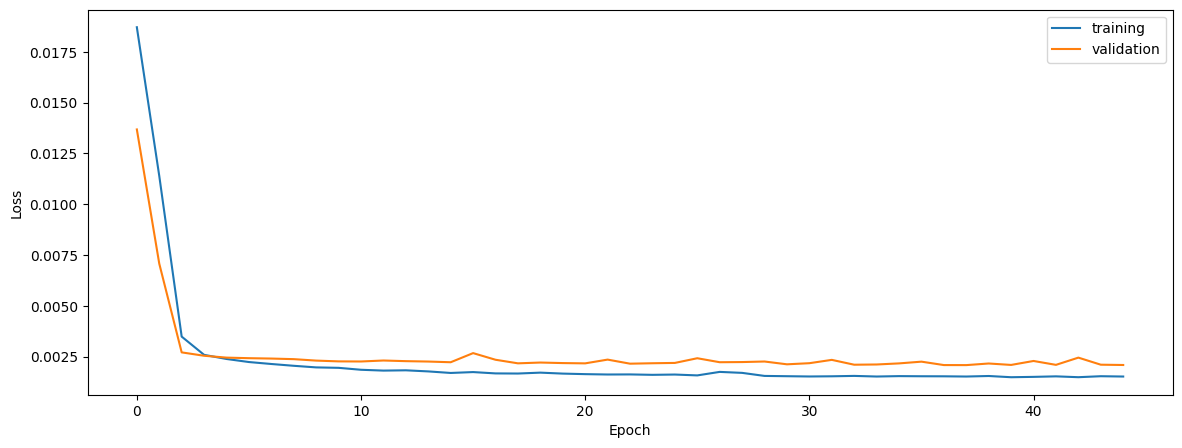

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9431378104113038
0.9230255840049602
0.9311970245545682


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9431378104113038
0.9230255840049602
0.9311970245545682


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9528649517874803
0.9371815541718941
0.9471224259507742


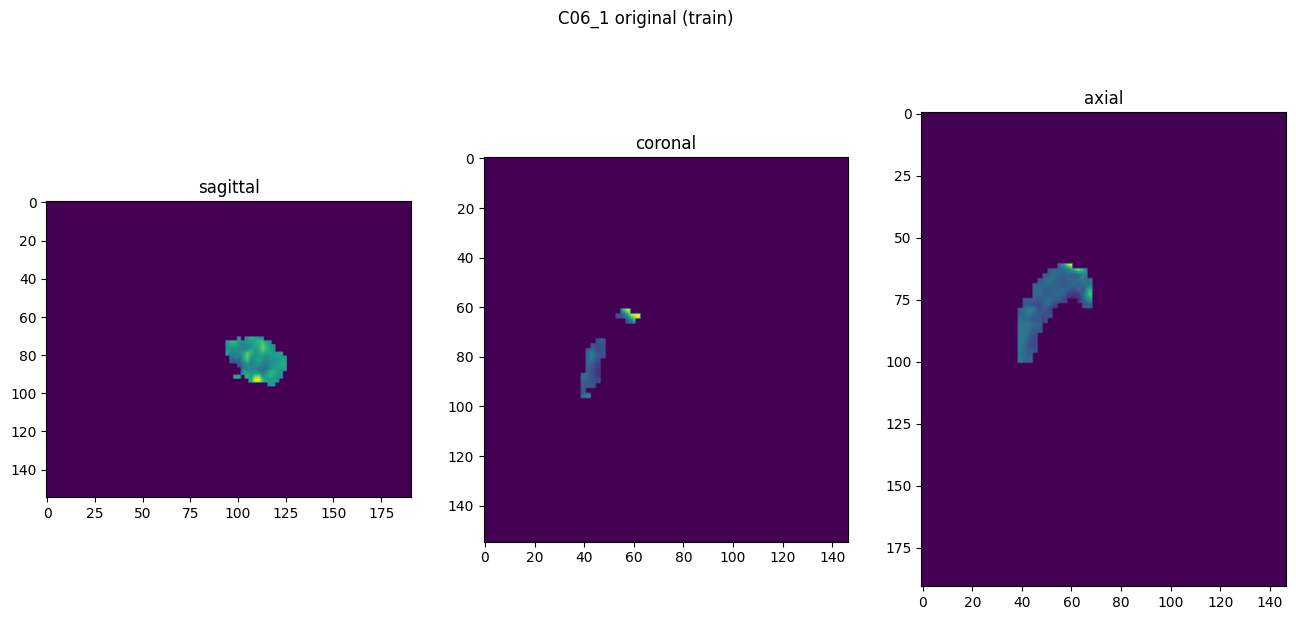

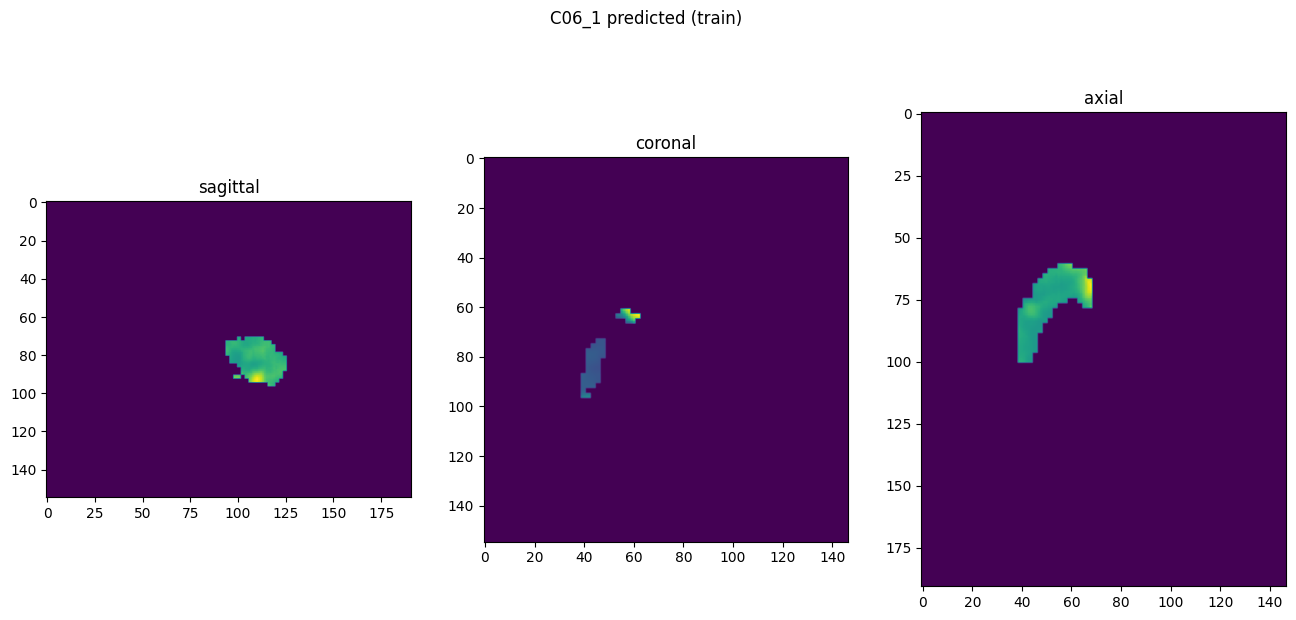

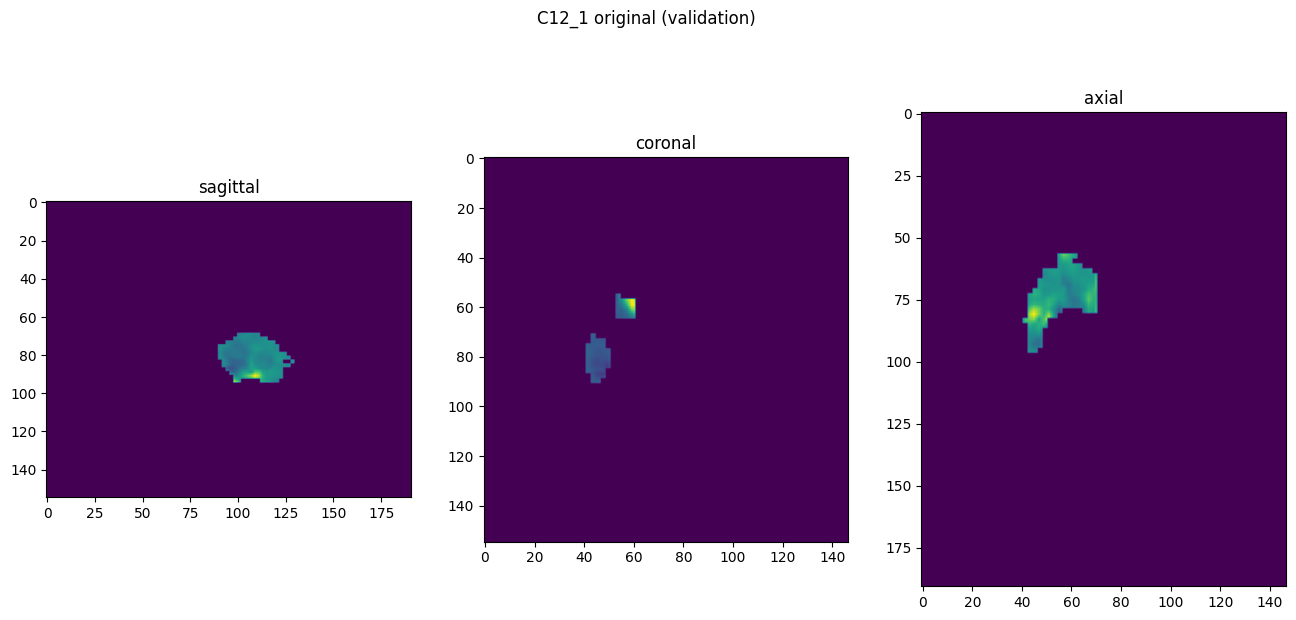

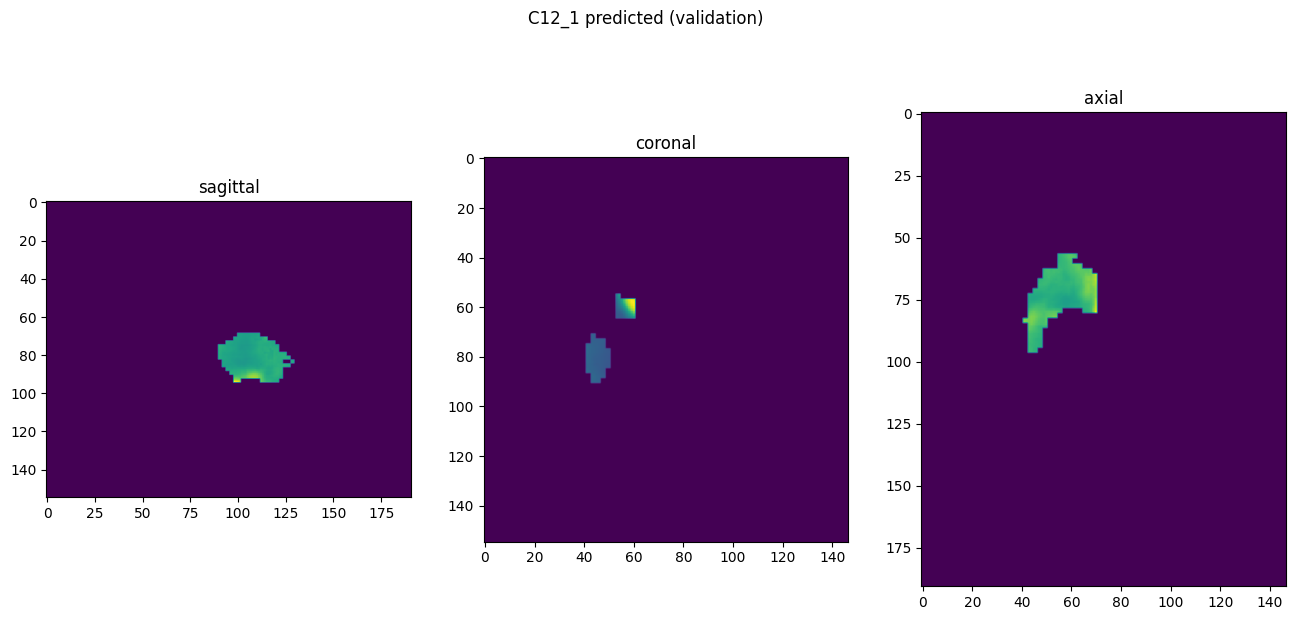

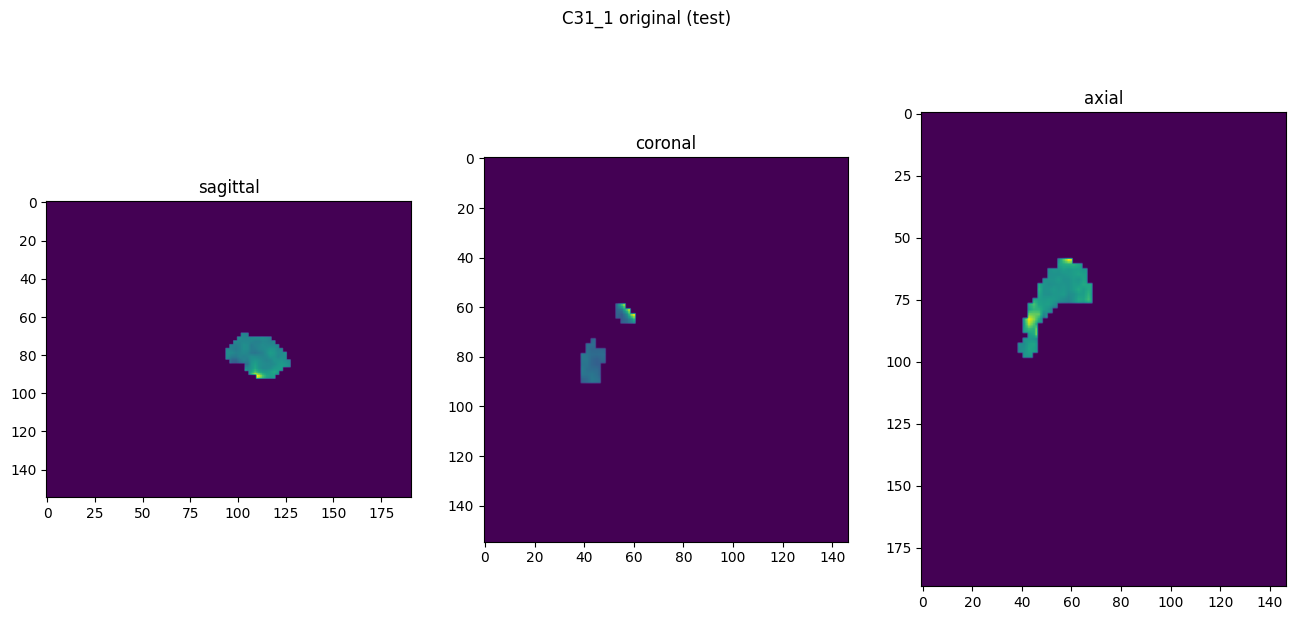

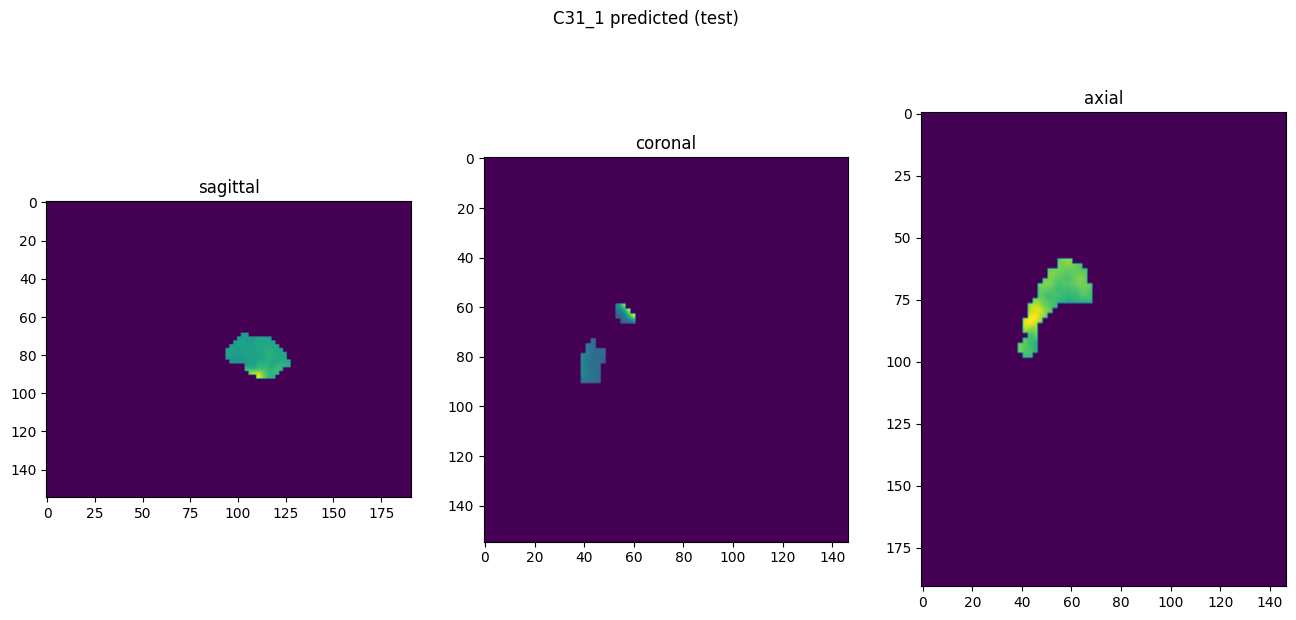

In [10]:
showResults(model, gen, threshold=None, background=False)